In [1]:
import numpy as np
import msgpack as mp
import msgpack_numpy as mpn
import cv2
from cv2 import aruco
import matplotlib.pyplot as plt
import os
import polars as pl
import sys

sys.path.append(os.path.dirname(os.getcwd()))

from datetime import datetime as dt
from support.pd_support import *
from support.ar_calculations import *

import toml
import plotly.io as pio
from tqdm import tqdm
from scipy.spatial.transform import Rotation as R

pio.renderers.default = "vscode"
import seaborn as sns

from scipy.signal import savgol_filter
from support.ar_calculations import calculate_rotmat_from_xyo, calculate_rotmat

from ultralytics import YOLO
from scipy import stats

In [2]:
_pth = toml.load("DATA_PATH.toml")["data_path"]["directory"]
_pth = os.path.dirname(_pth)
_parent_folder = "paper"
_calib_folder_name = "calibration_00"

_base_pth = os.path.join(_pth, "recorded_data", _parent_folder)
_folder_name = "armbo_orient_dynamic_t2"

_webcam_calib_folder = os.path.join(
    _pth, "recorded_data", _parent_folder, _calib_folder_name
)
_webcam_calib_folder = os.path.join(_webcam_calib_folder)
_webcam_calib_pth = os.path.join(_webcam_calib_folder, "webcam_calibration.msgpack")

with open(_webcam_calib_pth, "rb") as f:
    webcam_calib = mp.Unpacker(f, object_hook=mpn.decode)
    _temp = next(webcam_calib)
    _webcam_cam_mat = _temp[0]
    _webcam_dist = _temp[1]

ar_lframe_pth = os.path.join(
    _webcam_calib_folder, "armbo_orient_dynamic_rotmat2.msgpack"
)
with open(ar_lframe_pth, "rb") as f:
    ar_lframe = mp.Unpacker(f, object_hook=mpn.decode)
    _ar_lframe_rot = next(ar_lframe)
    _ar_lframe_org = next(ar_lframe)

# Mocap data

In [3]:
_om = get_rb_marker_name(2)
_xm = get_rb_marker_name(1)
_zm = get_rb_marker_name(4)

In [4]:
def estimatePoseSingleMarkers(corners, marker_size, mtx, distortion):
    marker_points = np.array(
        [
            [-marker_size / 2, marker_size / 2, 0],
            [marker_size / 2, marker_size / 2, 0],
            [marker_size / 2, -marker_size / 2, 0],
            [-marker_size / 2, -marker_size / 2, 0],
        ],
        dtype=np.float32,
    )
    trash = []
    rvecs = []
    tvecs = []
    for c in corners:
        nada, R, t = cv2.solvePnP(
            marker_points, c, mtx, distortion, True, flags=cv2.SOLVEPNP_ITERATIVE
        )

        if not (R is None or t is None):
            R = np.array(R).reshape(1, 3).tolist()
            t = np.array(t).reshape(1, 3).tolist()

        rvecs.append(R)
        tvecs.append(t)
    return rvecs, tvecs

In [5]:
# model_pth = os.path.join(os.getcwd(), "..",'models_save', 'mip_p2_60e_noise.pt')
# model_pth = os.path.join(os.getcwd(), "..",'models_save', 'mip_ar_200e_noise_v2.pt')
model_pth = os.path.join(os.getcwd(), "..", "models_save", "mip_ar_200e_noise.pt")
# model_pth = os.path.join(os.getcwd(), "..",'models_save', 'best.pt')
yolo_model = YOLO(model_pth)
# model_pth


marker_size = 0.05

marker_points = np.array(
    [
        [-marker_size / 2, marker_size / 2, 0],
        [marker_size / 2, marker_size / 2, 0],
        [marker_size / 2, -marker_size / 2, 0],
        [-marker_size / 2, -marker_size / 2, 0],
    ],
    dtype=np.float32,
)

In [6]:
_teensy_df = pl.read_csv(os.path.join(_base_pth, _folder_name, "imu01.csv"))
_teensy_df = _teensy_df.with_columns(
    pl.col("mz\r").str.replace("\r", "").cast(pl.Float64).alias("mz")
)
t_time = _teensy_df["rust_time"].to_numpy()
t_time = [dt.fromtimestamp(t) for t in t_time]
# t_time = [dt.strftime(t) for t in t_time]
teensy_df = pl.DataFrame({"time": t_time, "sync": _teensy_df["sync"]})
idx = None
for idx, i in enumerate(teensy_df["sync"]):
    if i == 1:
        break
teensy_start_time = teensy_df["time"][idx]

# Aruco parameters

ARUCO_PARAMETERS = aruco.DetectorParameters()
ARUCO_DICT = aruco.getPredefinedDictionary(aruco.DICT_ARUCO_MIP_36H12)
detector = aruco.ArucoDetector(ARUCO_DICT, ARUCO_PARAMETERS)
markerLength = 0.05
markerSeperation = 0.01

board = aruco.GridBoard(
    size=[1, 1],
    markerLength=markerLength,
    markerSeparation=markerSeperation,
    dictionary=ARUCO_DICT,
)

# timestamp
ts = []
ts_pth = os.path.join(_base_pth, _folder_name, "webcam_timestamp.msgpack")
ts_file = open(ts_pth, "rb")
ts_unpacker = mp.Unpacker(ts_file, object_hook=mpn.decode)
for ts_data in ts_unpacker:
    ts.append(ts_data)

In [7]:
# TODO: it dosen't work for case where we have repeated marker value + 1 adidtional marker detection

_video_pth = os.path.join(_base_pth, _folder_name, "webcam_color.msgpack")
_video_file = open(_video_pth, "rb")
_video_data = mp.Unpacker(_video_file, object_hook=mpn.decode)

default_ids = [12, 88, 89]

data_yolo = {"frame_id": [], "marker_ids": [], "corners": [], "tvec": [], "rvec": []}

counter = 0
NO_DETECTION = False

for _frame in tqdm(_video_data):
    shape = _frame.shape
    gray = cv2.cvtColor(_frame, cv2.COLOR_BGR2GRAY)
    ids = []
    # YOLO
    modelcorners = []
    yolo_results = yolo_model.predict(_frame, verbose=False, conf=0.8, half=True)[0]
    _mid, counts = np.unique(yolo_results.boxes.cls.cpu(), return_counts=True)
    # break
    if counts.size == 0:
        NO_DETECTION = True
    elif max(counts) > 1 and _mid.size == 1:
        _max_conf = np.argmax(yolo_results.boxes.conf.cpu())
        for _keys in yolo_results[_max_conf].keypoints.data:
            modelcorners.append(_keys[0:4].cpu().numpy())
    else:
        for _keys in yolo_results.keypoints.data:
            modelcorners.append(_keys[0:4].cpu().numpy())
        modelcorners = np.array(modelcorners)

    if not NO_DETECTION:  # if there are any detections else None
        _idx = yolo_results.boxes.cls.cpu().numpy()

        if max(counts) > 1:
            match _mid:
                case 0:
                    ids.append([12])
                case 1:
                    ids.append([88])
                case 2:
                    ids.append([89])
            ids = np.array(ids, dtype=np.int32)

        else:
            for i in _idx:
                match i:
                    case 0:
                        ids.append([12])
                    case 1:
                        ids.append([88])
                    case 2:
                        ids.append([89])
            ids = np.array(ids, dtype=np.int32)
    else:
        ids = None

    if len(modelcorners) != 0:  # if there are any detections else skip
        try:
            y_rvec, y_tvec = estimatePoseSingleMarkers(
                modelcorners, 0.05, _webcam_cam_mat, _webcam_dist
            )
        except:
            ids = None

    if ids is None:
        data_yolo["frame_id"].append(counter)
        data_yolo["marker_ids"].append(None)
        data_yolo["corners"].append(None)
        data_yolo["tvec"].append(None)
        data_yolo["rvec"].append(None)

    if ids is not None:
        data_yolo["frame_id"].append(counter)
        data_yolo["marker_ids"].append(ids)
        data_yolo["corners"].append(modelcorners)
        data_yolo["tvec"].append(y_tvec)
        data_yolo["rvec"].append(y_rvec)
    counter += 1
    NO_DETECTION = False
_video_file.close()

0it [00:00, ?it/s]

885it [00:15, 56.13it/s]


In [8]:
data = data_yolo.copy()
coordinate = {
    str(default_ids[0]): {"x": [], "y": [], "z": [], "rx": [], "ry": [], "rz": []},
    str(default_ids[1]): {"x": [], "y": [], "z": [], "rx": [], "ry": [], "rz": []},
    str(default_ids[2]): {"x": [], "y": [], "z": [], "rx": [], "ry": [], "rz": []},
}

doesnt_exist = []
# default_ids = [100, 49, 80]
zero_counter = 0
for i in range(len(data["frame_id"])):
    if data["marker_ids"][i] is not None:
        if default_ids[0] not in data["marker_ids"][i]:
            doesnt_exist.append(default_ids[0])
        if default_ids[1] not in data["marker_ids"][i]:
            doesnt_exist.append(default_ids[1])
        if default_ids[2] not in data["marker_ids"][i]:
            doesnt_exist.append(default_ids[2])

        _zero_counter = 0
        for j, _m in enumerate(data["marker_ids"][i]):
            if _m in default_ids:
                coordinate[str(_m[0])]["x"].append(data["tvec"][i][j][0][0])
                coordinate[str(_m[0])]["y"].append(data["tvec"][i][j][0][1])
                coordinate[str(_m[0])]["z"].append(data["tvec"][i][j][0][2])
                coordinate[str(_m[0])]["rx"].append(data["rvec"][i][j][0][0])
                coordinate[str(_m[0])]["ry"].append(data["rvec"][i][j][0][1])
                coordinate[str(_m[0])]["rz"].append(data["rvec"][i][j][0][2])

        for k in doesnt_exist:
            coordinate[str(k)]["x"].append(np.nan)
            coordinate[str(k)]["y"].append(np.nan)
            coordinate[str(k)]["z"].append(np.nan)
            coordinate[str(k)]["rx"].append(np.nan)
            coordinate[str(k)]["ry"].append(np.nan)
            coordinate[str(k)]["rz"].append(np.nan)

    else:
        for _k in default_ids:
            coordinate[str(_k)]["x"].append(np.nan)
            coordinate[str(_k)]["y"].append(np.nan)
            coordinate[str(_k)]["z"].append(np.nan)
            coordinate[str(_k)]["rx"].append(np.nan)
            coordinate[str(_k)]["ry"].append(np.nan)
            coordinate[str(_k)]["rz"].append(np.nan)

    doesnt_exist.clear()

## Getting time sync and trigger

In [9]:
ar_df_12 = pl.DataFrame(coordinate["12"])
_tts = pl.DataFrame(ts).rename({"column_0": "time", "column_1": "_sync"})
_sync = _tts["_sync"].to_numpy()
for i in range(len(_sync)):
    if _sync[i] == "NA":
        _sync[i] = np.nan
    else:
        _sync[i] = int(_sync[i])

_tts.insert_column(1, pl.Series("sync", np.array(_sync, dtype=np.float32)))
ar_df_12.insert_column(0, _tts["time"])
ar_df_12.insert_column(1, _tts["sync"])
ar_df_12 = ar_df_12.with_columns((pl.col("sync") / pl.col("sync")).alias("trigger"))

ar_df_88 = pl.DataFrame(coordinate["88"])
ar_df_89 = pl.DataFrame(coordinate["89"])
_

''

## Reading mocap

In [10]:
_mocap_pth = os.path.join(
    os.path.dirname(os.path.dirname(_video_pth)),
    _folder_name.split("_")[0],
    f"{_folder_name}.csv",
)
_mocap_df, st_time = read_rigid_body_csv(_mocap_pth)
_mocap_df = add_datetime_col(_mocap_df, st_time, "seconds")
_mocap_df = pl.from_pandas(_mocap_df)
_mocap_pth

'D:\\CMC\\pyprojects\\DeepVision\\recorded_data\\paper\\armbo\\armbo_orient_dynamic_t2.csv'

## Reading IMU data

In [11]:
timeoffset = 0.0
_imu_pth = os.path.join(_base_pth, _folder_name, "imu01.csv")
_imu_df = pl.read_csv(_imu_pth)

dt = _imu_df["mils"].diff().mean() / 1000
dt = 0.007
filter_size = 101
filter_order = 9
_mean_gx = _imu_df["gx"][:filter_size].mean()
_mean_gy = _imu_df["gy"][:filter_size].mean()
_mean_gz = _imu_df["gz"][:filter_size].mean()
_mean_ax = _imu_df["ax"][:filter_size].mean()
_mean_ay = _imu_df["ay"][:filter_size].mean()
_mean_az = _imu_df["az"][:filter_size].mean()

# subtracting mean from gyro
_imu_df = _imu_df.with_columns(
    [
        (pl.col("gx") - _mean_gx).alias("gx"),
        (pl.col("gy") - _mean_gy).alias("gy"),
        (pl.col("gz") - _mean_gz).alias("gz"),
    ]
)

# subtracting mean from accel
_imu_df = _imu_df.with_columns(
    [
        (pl.col("ax") - _mean_ax).alias("ax"),
        (pl.col("ay") - _mean_ay).alias("ay"),
        (pl.col("az") - _mean_az).alias("az"),
    ]
)

# apply savgol filter
_imu_df = _imu_df.with_columns(
    [
        pl.col("ax")
        .map_batches(lambda x: savgol_filter(x.to_numpy(), filter_size, filter_order))
        .explode(),
        pl.col("ay")
        .map_batches(lambda x: savgol_filter(x.to_numpy(), filter_size, filter_order))
        .explode(),
        pl.col("az")
        .map_batches(lambda x: savgol_filter(x.to_numpy(), filter_size, filter_order))
        .explode(),
    ]
)

_imu_df = _imu_df.with_columns(
    [
        (pl.col("gx").cum_sum() * dt * 9.81).alias("ang_x"),
        (pl.col("gy").cum_sum() * dt * 9.81).alias("ang_y"),
        (pl.col("gz").cum_sum() * dt * 9.81).alias("ang_z"),
    ]
)

_imu_df = _imu_df.with_columns(pl.col("sys_time").str.to_datetime().alias("time"))
_imu_df = _imu_df.with_columns(
    pl.col("time")
    .map_batches(lambda x: x + timedelta(seconds=timeoffset))
    .alias("time")
)

# change string to float
_imu_df = _imu_df.with_columns(
    pl.col("mz\r").str.replace("\r", "").cast(pl.Float64).alias("mz")
)

In [12]:
rb_angle_df = _mocap_df[["rb_ang_x", "rb_ang_y", "rb_ang_z", "rb_ang_w"]].to_numpy()
rb_angle = []
for i in range(len(rb_angle_df)):
    try:
        r = R.from_quat(rb_angle_df[i])
        rb_angle.append(r.as_euler("ZYX", degrees=True))
    except:
        rb_angle.append([np.nan, np.nan, np.nan])
        print(i)
rb_angle = np.array(rb_angle)

32


In [13]:
rb_angle_df = (
    _mocap_df[["rb_ang_x", "rb_ang_y", "rb_ang_z", "rb_ang_w"]]
    .fill_null(np.nan)
    .to_numpy()
)
rb_angle = []
for i in range(len(rb_angle_df)):
    try:
        r = R.from_quat(rb_angle_df[i])
        rb_angle.append(r.as_euler("ZYX", degrees=True))
    except:
        rb_angle.append([np.nan, np.nan, np.nan])
        print(i)
rb_angle = np.array(rb_angle)

32


In [14]:
_imu_df = _imu_df.with_columns(pl.col("sys_time").str.to_datetime().alias("sys_time"))

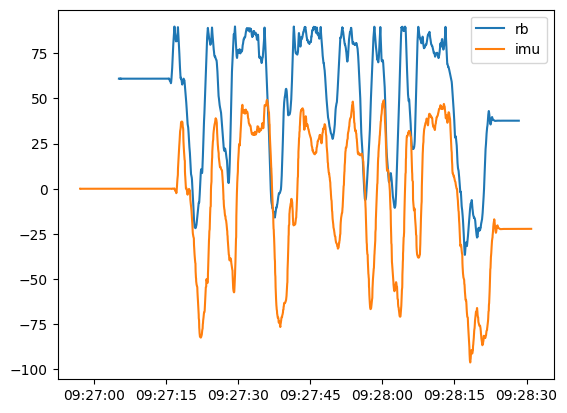

In [15]:
plt.plot(_mocap_df["time"], rb_angle[:, 1], label="rb")
plt.plot(_imu_df["time"], -_imu_df["ang_z"], label="imu")
plt.legend()

In [16]:
r_mats_12 = R.from_rotvec(ar_df_12[["rx", "ry", "rz"]].to_numpy()).as_matrix()
r_mats_88 = R.from_rotvec(ar_df_88[["rx", "ry", "rz"]].to_numpy()).as_matrix()
r_mats_89 = R.from_rotvec(ar_df_89[["rx", "ry", "rz"]].to_numpy()).as_matrix()

In [17]:
rA_m1_d = np.array([-0.05, 0.03, -0.055]).reshape(3, 1)
newdata = {"x": [], "y": [], "z": []}
for i in range(len(ar_df_12)):
    val = ar_df_12[["x", "y", "z"]][i].to_numpy().reshape(3, 1)
    pa_c = r_mats_12[i] @ rA_m1_d + val
    pa_b = _ar_lframe_rot.T @ (pa_c - _ar_lframe_org)
    val = pa_b
    if i == 0:
        initial = val
    if val is None:
        rval = np.nan
    else:
        rval = val
    reval = pa_b

    newdata["x"].append(reval[0])
    newdata["y"].append(reval[1])
    newdata["z"].append(reval[2])

rA_m1_88 = np.array([0.00, 0.02, -0.11]).reshape(3, 1)
newdata_88 = {"x": [], "y": [], "z": []}
for i in range(len(ar_df_88)):
    val_88 = ar_df_88[["x", "y", "z"]][i].to_numpy().reshape(3, 1)
    pa_c = r_mats_88[i] @ rA_m1_88 + val_88
    pa_b = _ar_lframe_rot.T @ (pa_c - _ar_lframe_org)
    val_88 = pa_b

    if i == 0:
        initial = ar_df_88[["x", "y", "z"]][0].to_numpy().reshape(3, 1)
    if val_88 is None:
        rval_88 = np.nan
    else:
        rval_88 = val_88

    reval_88 = val_88

    newdata_88["x"].append(reval_88[0])
    newdata_88["y"].append(reval_88[1])
    newdata_88["z"].append(reval_88[2])

rA_m1_89 = np.array([0.05, 0.03, -0.055]).reshape(3, 1)
newdata_89 = {"x": [], "y": [], "z": []}
for i in range(len(ar_df_12)):
    val_89 = ar_df_89[["x", "y", "z"]][i].to_numpy().reshape(3, 1)
    pa_c = r_mats_89[i] @ rA_m1_89 + val_89
    pa_b = _ar_lframe_rot.T @ (pa_c - _ar_lframe_org)
    val_89 = pa_b

    if i == 0:
        initial = ar_df_89[["x", "y", "z"]][0].to_numpy().reshape(3, 1)
    if val_89 is None:
        rval_89 = np.nan
    else:
        rval_89 = val_89

    reval_89 = val_89

    newdata_89["x"].append(reval_89[0])
    newdata_89["y"].append(reval_89[1])
    newdata_89["z"].append(reval_89[2])

In [18]:
if not (type(ar_df_12["time"][0])) == type(datetime.now()):
    ar_df_12 = ar_df_12.with_columns(
        [
            pl.Series(
                name="time",
                values=[datetime.fromtimestamp(i) for i in ar_df_12["time"].to_numpy()],
            ).alias("time")
        ]
    )

In [19]:
df = pd.DataFrame(newdata)
df_88 = pd.DataFrame(newdata_88)
df_89 = pd.DataFrame(newdata_89)

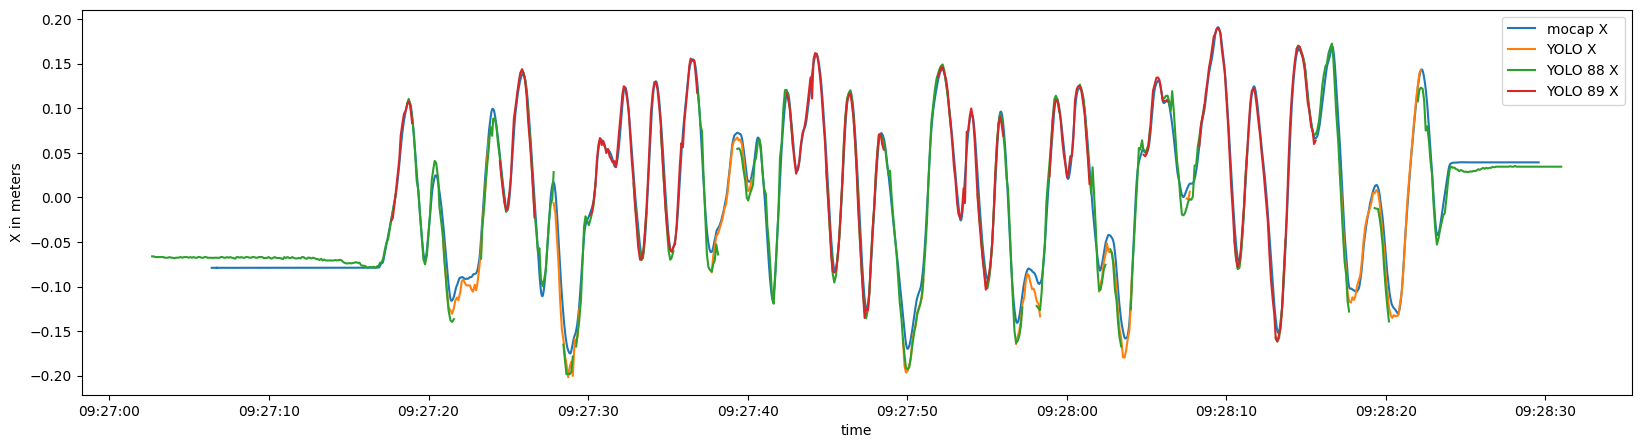

In [20]:
fig = plt.figure(figsize=(20, 5))

plt.plot(
    _mocap_df["time"] + timedelta(seconds=1.2),
    _mocap_df[_om["x"]] + 0.01,
    label="mocap X",
)
plt.plot(ar_df_12["time"], df["x"] - 0.03, label="YOLO X")
plt.plot(ar_df_12["time"], df_88["x"] - 0.03, label="YOLO 88 X")
plt.plot(ar_df_12["time"], df_89["x"], label="YOLO 89 X")
plt.ylabel("X in meters")
plt.xlabel("time")
plt.legend()

In [21]:
temp_df = pd.DataFrame(newdata)
temp_df_88 = pd.DataFrame(newdata_88)
temp_df_89 = pd.DataFrame(newdata_89)

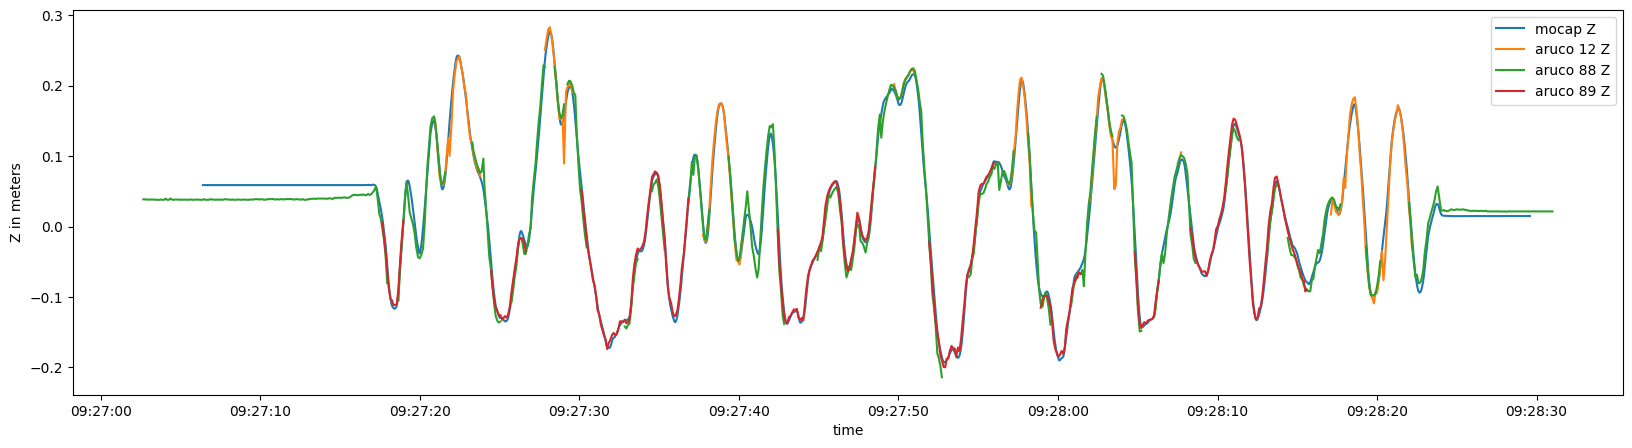

In [22]:
fig = plt.figure(figsize=(20, 5))

plt.plot(
    _mocap_df["time"] + timedelta(seconds=1.2), _mocap_df[_om["z"]], label="mocap Z"
)
plt.plot(ar_df_12["time"], np.array(newdata["z"]) - 0.01, label="aruco 12 Z")
plt.plot(ar_df_12["time"], np.array(newdata_88["z"]) - 0.03, label="aruco 88 Z")
plt.plot(ar_df_12["time"], temp_df_89["z"] - 0.03, label="aruco 89 Z")
plt.ylabel("Z in meters")
plt.xlabel("time")
plt.legend()

## Comparing against mocap

In [23]:
temp_12_x = np.array(newdata["x"]) + 0.03
temp_88_x = np.array(newdata_88["x"]) + 0.03
temp_89_x = np.array(newdata_89["x"])

temp_x = np.nanmean([temp_12_x, temp_88_x, temp_89_x], axis=0).reshape(-1)

temp_12_z = np.array(newdata["z"]) - 0.01
temp_88_z = np.array(newdata_88["z"]) - 0.03
temp_89_z = np.array(newdata_89["z"]) - 0.03

temp_z = np.nanmean([temp_12_z, temp_88_z, temp_89_z], axis=0).reshape(-1)


f_x = interp1d(
    (_mocap_df["time"] + timedelta(seconds=1.2)).dt.epoch(),
    _mocap_df[_om["x"]],
    fill_value="extrapolate",
)
f_z = interp1d(
    (_mocap_df["time"] + timedelta(seconds=1.2)).dt.epoch(),
    _mocap_df[_om["z"]],
    fill_value="extrapolate",
)
mocap_x = f_x(ar_df_12["time"].dt.epoch()) + 0.01
mocap_z = f_z(ar_df_12["time"].dt.epoch())

_diff_x = abs(temp_x - mocap_x) * 100
_diff_z = abs(temp_z - mocap_z) * 100

Text(0, 0.5, 'Error in cm')

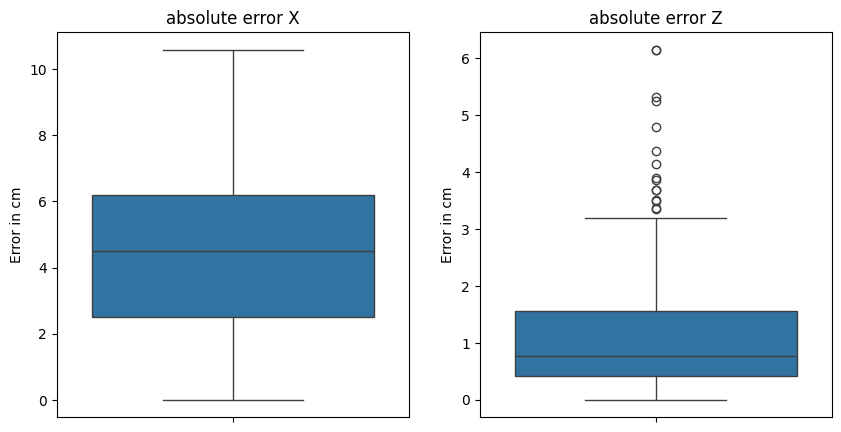

In [24]:
fig, axs = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(10, 5)

sns.boxplot(_diff_x, ax=axs[0])
axs[0].title.set_text("absolute error X")
axs[0].set_ylabel("Error in cm")

sns.boxplot(_diff_z, ax=axs[1])
axs[1].title.set_text("absolute error Z")
axs[1].set_ylabel("Error in cm")

In [25]:
pd.DataFrame(temp_x).isna().sum()

0    0
dtype: int64